# Michael DeCero
# CSC 578 Final Project (Time Series Kaggle)
# Spring 2024
# June 12, 2024

# Time series forecasting

## I set up this notebook independent of the TF Tutorial. While the tutorial heavily influenced my approach, I started this from scratch.

## Setup

In [1]:
#Import relevant packages
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
# Get file path
csv_path = tf.keras.utils.get_file(
    origin='https://reed.cs.depaul.edu/peterh/Essays/Metro_Interstate_reduced.csv',
    fname='Metro_Interstate_reduced.csv',
    cache_dir='/content', cache_subdir='sample_data')

csv_path

'/tmp\\.keras\\sample_data\\Metro_Interstate_reduced.csv'

In [3]:
# Convert file to dataframe
df = pd.read_csv(csv_path)

In [4]:
# x variables
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [5]:
df.shape

(40575, 9)

In [6]:
# target dataframe
y = pd.DataFrame(df.pop('traffic_volume'))

In [7]:
y.head()

,traffic_volume
0,5545
1,4516
2,4767
3,5026
4,4918


In [8]:
y.shape

(40575, 1)

In [9]:
#convert date_time to be set as index
date_time = pd.to_datetime(df.pop('date_time'), format='%Y.%m.%d %H:%M:%S')

In [10]:
print (date_time)

0       2012-10-02 09:00:00
1       2012-10-02 10:00:00
2       2012-10-02 11:00:00
3       2012-10-02 12:00:00
4       2012-10-02 13:00:00
                ...        
40570   2018-09-30 19:00:00
40571   2018-09-30 20:00:00
40572   2018-09-30 21:00:00
40573   2018-09-30 22:00:00
40574   2018-09-30 23:00:00
Name: date_time, Length: 40575, dtype: datetime64[ns]


## EDA

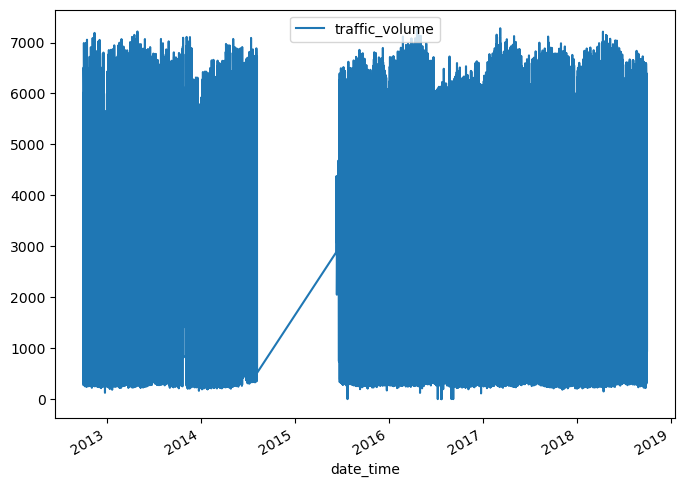

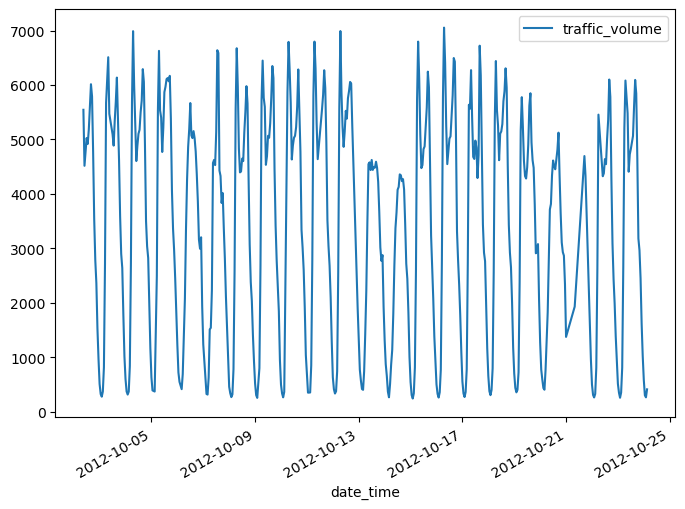

In [11]:
# Let's explore what the traffic volume looks like over the dataset
plot_cols = ['traffic_volume']
plot_features = y[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = y[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

#### What's up with the missing date values?

In [12]:
# Find rows with any null values
null_rows = y[y.isnull().any(axis=1)]

print(null_rows)

Empty DataFrame
Columns: [traffic_volume]
Index: []


##### We have missing date values around 2015, but we are do not have null values, so we can continue

#### x variables inspection

In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,40575.0,281.316763,13.816618,0.0,271.84,282.86,292.28,310.07
rain_1h,40575.0,0.318632,48.812640,0.0,0.00,0.00,0.00,9831.30
snow_1h,40575.0,0.000117,0.005676,0.0,0.00,0.00,0.00,0.51
clouds_all,40575.0,44.199162,38.683447,0.0,1.00,40.00,90.00,100.00


##### temp

##### We have values for temp that are 0 degrees kelvin. That has to be a data entry error. Let's update those records with another measurement.

In [14]:
# Filter the DataFrame to get rows where temp is 0 Kelvin
zero_kelvin_records = df[df['temp'] == 0]

print(zero_kelvin_records)

      holiday  temp  rain_1h  snow_1h  clouds_all weather_main  \
10079    None   0.0      0.0      0.0           0        Clear   
10080    None   0.0      0.0      0.0           0        Clear   
10081    None   0.0      0.0      0.0           0        Clear   
10082    None   0.0      0.0      0.0           0        Clear   
10127    None   0.0      0.0      0.0           0        Clear   
10128    None   0.0      0.0      0.0           0        Clear   
10129    None   0.0      0.0      0.0           0        Clear   
10130    None   0.0      0.0      0.0           0        Clear   
10131    None   0.0      0.0      0.0           0        Clear   
10132    None   0.0      0.0      0.0           0        Clear   

      weather_description  
10079        sky is clear  
10080        sky is clear  
10081        sky is clear  
10082        sky is clear  
10127        sky is clear  
10128        sky is clear  
10129        sky is clear  
10130        sky is clear  
10131        sky is c

##### What is the temp of the previous and subsequent records?

In [15]:
# Find the indexes where temp is 0 Kelvin
zero_kelvin_indexes = df[df['temp'] == 0].index

# Get the previous indexes
previous_indexes = zero_kelvin_indexes - 7

# Filter the DataFrame to get the rows at these previous indexes
previous_records = df.loc[previous_indexes]

print("Previous records for indexes where temp is 0 Kelvin:")
print(previous_records)

Previous records for indexes where temp is 0 Kelvin:
      holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
10072    None  257.11      0.0      0.0           0        Clear   
10073    None  256.09      0.0      0.0           0        Clear   
10074    None  255.93      0.0      0.0           0        Clear   
10075    None  256.22      0.0      0.0           0        Clear   
10120    None  259.49      0.0      0.0           0        Clear   
10121    None  258.19      0.0      0.0           0        Clear   
10122    None  257.04      0.0      0.0           0        Clear   
10123    None  256.51      0.0      0.0           0        Clear   
10124    None  255.59      0.0      0.0           0        Clear   
10125    None  255.48      0.0      0.0           0        Clear   

      weather_description  
10072        sky is clear  
10073        sky is clear  
10074        sky is clear  
10075        sky is clear  
10120        sky is clear  
10121        sky is clear  
10

##### Now, let's replace the 0 degrees kelvin records with an average of the previous record temps

In [16]:
# Calculate the average temperature of the previous records
average_temp = df.loc[previous_indexes, 'temp'].mean()

# Replace 0 Kelvin with the average temperature
df.loc[zero_kelvin_indexes, 'temp'] = average_temp

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,40575.0,281.380045,13.097275,243.39,271.84,282.86,292.28,310.07
rain_1h,40575.0,0.318632,48.812640,0.00,0.00,0.00,0.00,9831.30
snow_1h,40575.0,0.000117,0.005676,0.00,0.00,0.00,0.00,0.51
clouds_all,40575.0,44.199162,38.683447,0.00,1.00,40.00,90.00,100.00


#### rain_1h

##### We also have a max rain fall of 9831. That's absurd

In [18]:
# Calculate basic statistics
rain_stats = df['rain_1h'].describe()
print(rain_stats)

# Identify outliers (values significantly higher than typical rain measurements)
outlier_threshold = 2 * rain_stats['std']  
outliers = df[df['rain_1h'] > outlier_threshold]
print("Outliers:")
print(outliers)

count    40575.000000
mean         0.318632
std         48.812640
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       9831.300000
Name: rain_1h, dtype: float64
Outliers:
      holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
21224    None  302.11   9831.3      0.0          75         Rain   

      weather_description  
21224     very heavy rain  


##### Only 1 record. Let's replace it with the rain_1h average of all records with "very heavy rain"

In [19]:
# Calculate the mean rain_1h value for the "very heavy rain" description
very_heavy_rain_mean = df[df['weather_description'] == 'Very heavy rain']['rain_1h'].mean()

# Replace outliers in rain_1h with the mean value of "very heavy rain"
df['rain_1h'] = np.where(df['rain_1h'] > outlier_threshold, very_heavy_rain_mean, df['rain_1h'])

In [20]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,40575.0,281.380045,13.097275,243.39,271.84,282.86,292.28,310.07
rain_1h,40574.0,0.076334,0.769635,0.00,0.00,0.00,0.00,55.63
snow_1h,40575.0,0.000117,0.005676,0.00,0.00,0.00,0.00,0.51
clouds_all,40575.0,44.199162,38.683447,0.00,1.00,40.00,90.00,100.00


### Handling categorical values

#### Remove weather description because we have enough information with other attributes

In [21]:
# Remove the 'weather_description' column
df.drop(columns=['weather_description'], inplace=True)

df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main
0,None,288.28,0.0,0.0,40,Clouds
1,None,289.36,0.0,0.0,75,Clouds
2,None,289.58,0.0,0.0,90,Clouds
3,None,290.13,0.0,0.0,90,Clouds
4,None,291.14,0.0,0.0,75,Clouds


#### Change holiday to a binary measurement

In [22]:
# Transform 'holiday' column to binary
df['holiday'] = df['holiday'].apply(lambda x: 0 if x == 'None' else 1)

df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main
0,0,288.28,0.0,0.0,40,Clouds
1,0,289.36,0.0,0.0,75,Clouds
2,0,289.58,0.0,0.0,90,Clouds
3,0,290.13,0.0,0.0,90,Clouds
4,0,291.14,0.0,0.0,75,Clouds


In [23]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
holiday,40575.0,0.001306,0.036119,0.00,0.00,0.00,0.00,1.00
temp,40575.0,281.380045,13.097275,243.39,271.84,282.86,292.28,310.07
rain_1h,40574.0,0.076334,0.769635,0.00,0.00,0.00,0.00,55.63
snow_1h,40575.0,0.000117,0.005676,0.00,0.00,0.00,0.00,0.51
clouds_all,40575.0,44.199162,38.683447,0.00,1.00,40.00,90.00,100.00


### One-hot encode weather_main

In [24]:
# Get the unique values in the 'weather_main' column
unique_weather_main = df['weather_main'].unique()

print("Unique values in 'weather_main' column:")
print(unique_weather_main)

Unique values in 'weather_main' column:
['Clouds' 'Clear' 'Rain' 'Drizzle' 'Mist' 'Fog' 'Thunderstorm' 'Haze'
 'Snow' 'Squall' 'Smoke']


In [25]:
# One-hot encode the 'weather_main' column
df_encoded = pd.get_dummies(df, columns=['weather_main'])

df_encoded.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
0,0,288.28,0.0,0.0,40,0,1,0,0,0,0,0,0,0,0,0
1,0,289.36,0.0,0.0,75,0,1,0,0,0,0,0,0,0,0,0
2,0,289.58,0.0,0.0,90,0,1,0,0,0,0,0,0,0,0,0
3,0,290.13,0.0,0.0,90,0,1,0,0,0,0,0,0,0,0,0
4,0,291.14,0.0,0.0,75,0,1,0,0,0,0,0,0,0,0,0


In [26]:
df_encoded.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
holiday,40575.0,0.001306,0.036119,0.00,0.00,0.00,0.00,1.00
temp,40575.0,281.380045,13.097275,243.39,271.84,282.86,292.28,310.07
rain_1h,40574.0,0.076334,0.769635,0.00,0.00,0.00,0.00,55.63
snow_1h,40575.0,0.000117,0.005676,0.00,0.00,0.00,0.00,0.51
clouds_all,40575.0,44.199162,38.683447,0.00,1.00,40.00,90.00,100.00
weather_main_Clear,40575.0,0.329415,0.470006,0.00,0.00,0.00,1.00,1.00
weather_main_Clouds,40575.0,0.372717,0.483534,0.00,0.00,0.00,1.00,1.00
weather_main_Drizzle,40575.0,0.012693,0.111945,0.00,0.00,0.00,0.00,1.00
weather_main_Fog,40575.0,0.004954,0.070209,0.00,0.00,0.00,0.00,1.00
weather_main_Haze,40575.0,0.018879,0.136098,0.00,0.00,0.00,0.00,1.00


### Feature engineering

#### Time

##### `Date Time` column is very useful, but not in this form. Start by converting it to seconds:

In [27]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

##### Use sine and cosine transforms to clear "Time of day" and "Time of year" signals:

In [28]:
# Define the period for the hour (24 hours)
day = 24*60*60
year = (365.2425)*day

df_encoded['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_encoded['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_encoded['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_encoded['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

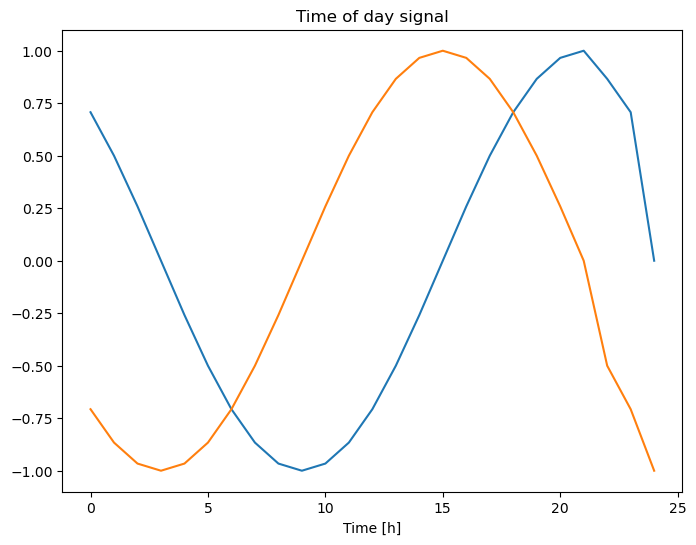

In [29]:
plt.plot(np.array(df_encoded['Day sin'])[:25])
plt.plot(np.array(df_encoded['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

### This is where our x variable dataset stands after we have inspected all the variables and trasnformed them to be readable by our neural network

In [30]:
df_encoded.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
holiday,40575.0,0.001306,0.036119,0.00,0.000000,0.000000e+00,0.000000,1.00
temp,40575.0,281.380045,13.097275,243.39,271.840000,2.828600e+02,292.280000,310.07
rain_1h,40574.0,0.076334,0.769635,0.00,0.000000,0.000000e+00,0.000000,55.63
snow_1h,40575.0,0.000117,0.005676,0.00,0.000000,0.000000e+00,0.000000,0.51
clouds_all,40575.0,44.199162,38.683447,0.00,1.000000,4.000000e+01,90.000000,100.00
weather_main_Clear,40575.0,0.329415,0.470006,0.00,0.000000,0.000000e+00,1.000000,1.00
weather_main_Clouds,40575.0,0.372717,0.483534,0.00,0.000000,0.000000e+00,1.000000,1.00
weather_main_Drizzle,40575.0,0.012693,0.111945,0.00,0.000000,0.000000e+00,0.000000,1.00
weather_main_Fog,40575.0,0.004954,0.070209,0.00,0.000000,0.000000e+00,0.000000,1.00
weather_main_Haze,40575.0,0.018879,0.136098,0.00,0.000000,0.000000e+00,0.000000,1.00


### Split the data

In [31]:
from sklearn.model_selection import train_test_split

# Specify the exact number of records for the test set
test_size = 5000

# Calculate the test size as a fraction
test_size_fraction = test_size / len(df_encoded)

# Splitting the x variables dataframe
train_df, test_df = train_test_split(df_encoded, test_size=test_size_fraction, random_state=42, shuffle=False)

#Splitting the target variable dataframe
y_train, y_test = train_test_split(y, test_size=test_size_fraction, random_state=42, shuffle=False)

In [32]:
test_df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,Day sin,Day cos,Year sin,Year cos
35575,0,271.36,0.0,0.0,90,0,0,0,0,0,0,0,0,1,0,0,-2.588190e-01,0.965926,0.894116,0.447835
35576,0,271.43,0.0,0.0,90,0,0,0,0,0,0,0,0,1,0,0,-3.769765e-12,1.000000,0.894437,0.447194
35577,0,271.43,0.0,0.0,90,0,0,0,0,0,0,0,0,1,0,0,2.588190e-01,0.965926,0.894757,0.446553
35578,0,271.36,0.0,0.0,90,0,0,0,0,0,0,0,0,1,0,0,5.000000e-01,0.866025,0.895077,0.445911
35579,0,271.28,0.0,0.0,90,0,0,0,0,0,0,0,0,1,0,0,7.071068e-01,0.707107,0.895397,0.445270


In [33]:
y_test.head()

,traffic_volume
35575,599
35576,308
35577,242
35578,231
35579,335


### Normalize the data between 0 and 1 for all features

In [34]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Noramalize
X_train_scaled = scaler.fit_transform(train_df)
X_test_scaled = scaler.fit_transform(test_df)

# Create dataframes with the original indexes
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=train_df.index, columns=train_df.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=test_df.index, columns=test_df.columns)

In [35]:
# Normalized training data summary
X_train_scaled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
holiday,35575.0,0.001377,0.037088,0.0,0.000000,0.000000,0.000000,1.0
temp,35575.0,0.570488,0.202504,0.0,0.427093,0.582113,0.740015,1.0
rain_1h,35574.0,0.001348,0.014436,0.0,0.000000,0.000000,0.000000,1.0
snow_1h,35575.0,0.000262,0.011886,0.0,0.000000,0.000000,0.000000,1.0
clouds_all,35575.0,0.448855,0.387147,0.0,0.010000,0.400000,0.900000,1.0
weather_main_Clear,35575.0,0.327421,0.469279,0.0,0.000000,0.000000,1.000000,1.0
weather_main_Clouds,35575.0,0.381420,0.485742,0.0,0.000000,0.000000,1.000000,1.0
weather_main_Drizzle,35575.0,0.012790,0.112368,0.0,0.000000,0.000000,0.000000,1.0
weather_main_Fog,35575.0,0.004975,0.070362,0.0,0.000000,0.000000,0.000000,1.0
weather_main_Haze,35575.0,0.019002,0.136534,0.0,0.000000,0.000000,0.000000,1.0


In [36]:
# Normalized test data summary
X_test_scaled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
holiday,5000.0,0.000800,0.028276,0.0,0.000000,0.000000,0.000000,1.0
temp,5000.0,0.571237,0.206083,0.0,0.427806,0.628719,0.721142,1.0
rain_1h,5000.0,0.008089,0.044069,0.0,0.000000,0.000000,0.000000,1.0
snow_1h,5000.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
clouds_all,5000.0,0.427348,0.414230,0.0,0.010870,0.434783,0.815217,1.0
weather_main_Clear,5000.0,0.343600,0.474957,0.0,0.000000,0.000000,1.000000,1.0
weather_main_Clouds,5000.0,0.310800,0.462867,0.0,0.000000,0.000000,1.000000,1.0
weather_main_Drizzle,5000.0,0.012000,0.108896,0.0,0.000000,0.000000,0.000000,1.0
weather_main_Fog,5000.0,0.004800,0.069122,0.0,0.000000,0.000000,0.000000,1.0
weather_main_Haze,5000.0,0.018000,0.132964,0.0,0.000000,0.000000,0.000000,1.0


##### Combine scaled features with target

In [37]:
train_df = pd.concat([X_train_scaled_df, y_train], axis=1)
test_df = pd.concat([X_test_scaled_df, y_test], axis=1)

In [38]:
#Make sure there are no NaNs
train_df.fillna(train_df.mean(), inplace=True)

In [133]:
train_df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,...,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,Day sin,Day cos,Year sin,Year cos,traffic_volume
0,0.0,0.692213,0.0,0.0,0.40,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.853553,0.146447,0.000117,0.510821,5545
1,0.0,0.708867,0.0,0.0,0.75,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.750000,0.066987,0.000125,0.511179,4516
2,0.0,0.712259,0.0,0.0,0.90,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.629410,0.017037,0.000133,0.511537,4767
3,0.0,0.720740,0.0,0.0,0.90,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.500000,0.000000,0.000142,0.511896,5026
4,0.0,0.736315,0.0,0.0,0.75,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.370590,0.017037,0.000150,0.512254,4918


In [132]:
test_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
holiday,5000.0,0.000800,0.028276,0.0,0.000000,0.000000,0.000000,1.0
temp,5000.0,0.571237,0.206083,0.0,0.427806,0.628719,0.721142,1.0
rain_1h,5000.0,0.008089,0.044069,0.0,0.000000,0.000000,0.000000,1.0
snow_1h,5000.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
clouds_all,5000.0,0.427348,0.414230,0.0,0.010870,0.434783,0.815217,1.0
weather_main_Clear,5000.0,0.343600,0.474957,0.0,0.000000,0.000000,1.000000,1.0
weather_main_Clouds,5000.0,0.310800,0.462867,0.0,0.000000,0.000000,1.000000,1.0
weather_main_Drizzle,5000.0,0.012000,0.108896,0.0,0.000000,0.000000,0.000000,1.0
weather_main_Fog,5000.0,0.004800,0.069122,0.0,0.000000,0.000000,0.000000,1.0
weather_main_Haze,5000.0,0.018000,0.132964,0.0,0.000000,0.000000,0.000000,1.0


### Data Windowing

In [41]:
# Create the windowed datasets
def create_windowed_dataset(df, target_column, input_window, prediction_offset):
    X = []
    y = []
    for i in range(len(df) - input_window - prediction_offset + 1):
        X.append(df.iloc[i:i+input_window].drop(columns=[target_column]).values)
        y.append(df.iloc[i+input_window+prediction_offset-1][target_column])
    return np.array(X), np.array(y)

In [42]:
# Define the window parameters
input_window = 12
prediction_offset = 3

In [43]:
X_train, y_train = create_windowed_dataset(train_df, 'traffic_volume', input_window, prediction_offset)
X_test, y_test = create_windowed_dataset(test_df, 'traffic_volume', input_window, prediction_offset)

print("Training set shapes:", X_train.shape, y_train.shape)
print("Testing set shapes:", X_test.shape, y_test.shape)

Training set shapes: (35561, 12, 20) (35561,)
Testing set shapes: (4986, 12, 20) (4986,)


### Baseline LSTM Model

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error

# LSTM model
lstm_model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predictions and evaluation
y_pred_lstm = lstm_model.predict(X_test)
lstm_mae = mean_absolute_error(y_test, y_pred_lstm)

print("LSTM Model MAE:", lstm_mae)

Epoch 1/10
1112/1112 [==============================] - 6s 4ms/step - loss: 14451494.0000 - val_loss: 14871017.0000
Epoch 2/10
1112/1112 [==============================] - 4s 4ms/step - loss: 14089746.0000 - val_loss: 14509585.0000
Epoch 3/10
1112/1112 [==============================] - 4s 4ms/step - loss: 13742933.0000 - val_loss: 14156977.0000
Epoch 4/10
1112/1112 [==============================] - 4s 4ms/step - loss: 13404159.0000 - val_loss: 13811753.0000
Epoch 5/10
1112/1112 [==============================] - 4s 4ms/step - loss: 13072019.0000 - val_loss: 13472888.0000
Epoch 6/10
1112/1112 [==============================] - 4s 4ms/step - loss: 12743853.0000 - val_loss: 13131415.0000
Epoch 7/10
1112/1112 [==============================] - 4s 4ms/step - loss: 12414094.0000 - val_loss: 12797029.0000
Epoch 8/10
1112/1112 [==============================] - 4s 4ms/step - loss: 12094196.0000 - val_loss: 12470768.0000
Epoch 9/10
1112/1112 [==============================] - 4s 4ms/step - lo

### More complex model

In [61]:
from tensorflow.keras.layers import GRU, Dropout, Bidirectional, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [98]:
# Define a more complex model with additional CNN layers and Batch Normalization
def build_complex_model_with_batch_norm(input_shape, 
                                        recurrent_units=100, 
                                        dropout_rate=0.3, 
                                        num_recurrent_layers=3, 
                                        learning_rate=0.001, 
                                        use_bidirectional=False):
    
    model = Sequential()
    
    # Add multiple CNN layers with Batch Normalization
    model.add(Conv1D(filters=8, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling1D(pool_size=1))

    model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling1D(pool_size=1))

    model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling1D(pool_size=1))

    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling1D(pool_size=1))

    model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling1D(pool_size=1))
    
    model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling1D(pool_size=1))

    # Add LSTM layers with Batch Normalization
    for i in range(num_recurrent_layers):
        if i == 0:
            if use_bidirectional:
                model.add(Bidirectional(LSTM(recurrent_units, return_sequences=True)))
            else:
                model.add(LSTM(recurrent_units, return_sequences=True))
        else:
            if use_bidirectional:
                model.add(Bidirectional(LSTM(recurrent_units, return_sequences=(i < num_recurrent_layers - 1))))
            else:
                model.add(LSTM(recurrent_units, return_sequences=(i < num_recurrent_layers - 1)))
        
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_absolute_error')

    return model

In [99]:
# Parameters for experimentation
batch_size = 64
recurrent_units = 100
dropout_rate = 0.3
num_recurrent_layers = 3
learning_rate = 0.0001
use_bidirectional = True


In [100]:
# Build and compile the model
input_shape = (X_train.shape[1], X_train.shape[2])
complex_model_with_batch_norm = build_complex_model_with_batch_norm(input_shape, 
                                                                    recurrent_units, 
                                                                    dropout_rate, 
                                                                    num_recurrent_layers, 
                                                                    learning_rate, 
                                                                    use_bidirectional)

In [101]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


In [102]:
# Train the model
history = complex_model_with_batch_norm.fit(X_train, 
                                            y_train, 
                                            epochs=100, 
                                            batch_size=batch_size, 
                                            validation_data=(X_test, y_test),
                                            callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
556/556 [==============================] - 93s 152ms/step - loss: 3278.6707 - val_loss: 3371.3818
Epoch 2/100
556/556 [==============================] - 81s 146ms/step - loss: 3276.7590 - val_loss: 3370.2415
Epoch 3/100
556/556 [==============================] - 81s 146ms/step - loss: 3272.8000 - val_loss: 3364.1499
Epoch 4/100
556/556 [==============================] - 81s 146ms/step - loss: 3266.4326 - val_loss: 3351.8433
Epoch 5/100
556/556 [==============================] - 81s 146ms/step - loss: 3257.8552 - val_loss: 3341.1667
Epoch 6/100
556/556 [==============================] - 81s 146ms/step - loss: 3247.2998 - val_loss: 3328.4041
Epoch 7/100
556/556 [==============================] - 82s 147ms/step - loss: 3235.0520 - val_loss: 3304.7932
Epoch 8/100
556/556 [==============================] - 83s 149ms/step - loss: 3221.1624 - val_loss: 3288.4045
Epoch 9/100
556/556 [==============================] - 84s 151ms/step - loss: 3205.6907 - val_loss: 3269.0598
Epoch 10/1

556/556 [==============================] - 90s 163ms/step - loss: 779.7057 - val_loss: 575.3712
Epoch 76/100
556/556 [==============================] - 90s 162ms/step - loss: 775.3079 - val_loss: 560.4013
Epoch 77/100
556/556 [==============================] - 91s 163ms/step - loss: 779.3695 - val_loss: 568.7429
Epoch 78/100
556/556 [==============================] - 90s 163ms/step - loss: 770.6460 - val_loss: 558.9766
Epoch 79/100
556/556 [==============================] - 91s 163ms/step - loss: 771.1077 - val_loss: 566.8616
Epoch 80/100
556/556 [==============================] - 91s 163ms/step - loss: 769.6512 - val_loss: 562.0726
Epoch 81/100
556/556 [==============================] - 91s 164ms/step - loss: 764.4833 - val_loss: 548.6124
Epoch 82/100
556/556 [==============================] - 91s 164ms/step - loss: 763.3140 - val_loss: 552.1702
Epoch 83/100
556/556 [==============================] - 91s 164ms/step - loss: 766.2045 - val_loss: 556.5100
Epoch 84/100
556/556 [==========

In [96]:
# Generate predictions and evaluate the model
y_pred = complex_model_with_batch_norm.predict(X_test)
mae_y_pred = mean_absolute_error(y_test, y_pred)

print("Complex Model MAE:", mae_y_pred)

156/156 [==============================] - 3s 8ms/step
Complex Model MAE: 695.3991360700709


### Visualize predictions

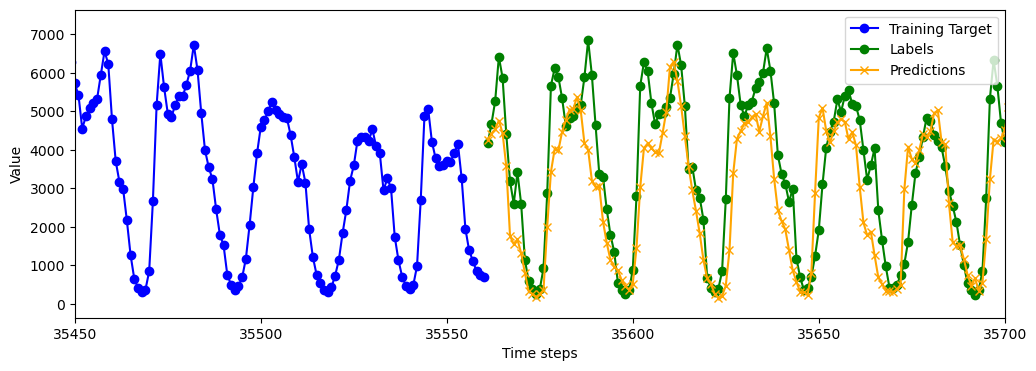

In [128]:
# Plot the results
plt.figure(figsize=(12, 4))

# Plot training data
plt.plot(np.arange(len(y_train.flatten())), y_train.flatten(), label='Training Target', marker='o', color='blue')

# Plot test labels
plt.plot(np.arange(len(y_train.flatten()), len(y_train.flatten()) + len(y_test.flatten())), y_test.flatten(), label='Labels', marker='o', color='green')

# Plot predictions
plt.plot(np.arange(len(y_train.flatten()), len(y_train.flatten()) + len(y_pred.flatten())), y_pred.flatten(), label='Predictions', marker='x', color='orange')

plt.xlabel('Time steps')
plt.ylabel('Value')
plt.legend()

# Set x-axis limits to show only the range from 35000 to 37000
plt.xlim(35450, 35700)

plt.show()

### Create submission csv

In [97]:
#Ensure the right ids are indexed
start_id = 35589
end_id = 40574
ids = np.arange(start_id, end_id + 1)
predictions = y_pred.flatten()[:len(ids)]

#create submission dataframe
submission_df = pd.DataFrame({
    'id': ids,
    'prediction': predictions
})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False, header=True, float_format='%.1f')

print("Submission file created successfully.")

Submission file created successfully.
